# **Nature articles** - Topic Modeling with BERTopic

In this notebook we will be exploring nature articles using BERTopic to create topics range from 1886-2021. 

## BERTopic
BERTopic is a topic modeling technique that leverages transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. 


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Installing BERTopic** and other related packages

In [2]:
%%capture
!pip install bertopic
!pip3 install pickle5
!pip install --upgrade tbb
!pip install --upgrade numba

## Restart the Notebook
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

# Import modules/functions

In [1]:
import os
import glob
import pandas as pd
import pickle5
import pickle
from bertopic import BERTopic

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Data
Using nature scraper to extract info from 
https://www.nature.com/nature/articles?type=article, including:
  - Article title
  - Publish year
  - Accesses
  - Citations
  - Altmetric
  - Affiliations
  - Corresponding Author
  - DOIS
  - Subjects
  - Abstract

In [2]:
# copy the data from MyDrive to the /content
!mkdir -p /content/nature_bertopic/data
base = '/content/nature_bertopic/data'
data_path = '/content/drive/MyDrive/nature_scraping_bertopic/data'
 
files = glob.glob(f'{base}/*')
 
for f in files:
    os.remove(f)
 
!cp {data_path}/* {base}

In [3]:
len(glob.glob('nature_bertopic/data/*'))

205

In [4]:
data_name_list = glob.glob(os.path.join(base, "*.pkl"))

In [5]:
def read_data(data_source):
  '''Read data and convert to pd.dataframe'''
  data_list = []
  counter = 0
  for data_name in data_source:
    with open(f'{data_name}', "rb") as f:
      data = pickle5.load(f)
      # data = pd.read_pickle(f)
      data_list.append(data)
      counter += 1
      if counter % 50 == 0:
        print(f'{counter} files have been loaded.')
  df = pd.concat(data_list)
  print(f'{counter} files loaded!')   
  return df   

In [6]:
df = read_data(data_name_list)

50 files have been loaded.
100 files have been loaded.
150 files have been loaded.
200 files have been loaded.
205 files loaded!


In [8]:
df.shape
# The df contains 20000 records and 10 columns information for each record from https://www.nature.com/nature/articles?type=article. 

(20000, 10)

### Abstract preparation
- remove entire empty title item
- for empty abstract item, copy titles to abstracts (8451 items)
- drop short title as abstract
- left ~16500 items for Bertopic

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
# rop the full empty row
df.drop(df['titles'][(df['titles'].isnull())].index, inplace=True)

In [11]:
print('Number of empty pubdates items: ', df['pub_dates'].isnull().sum())

Number of empty pubdates items:  0


In [12]:
print('Number of empty abstract items: ', df['abstract'].isnull().sum())
df[(df['abstract'].isnull())].head()

Number of empty abstract items:  8540


titles  ... abstract
114  Chemistry of the Feulgen and Dische Nucleal Re...  ...      NaN
115               Ant Gynandromorphs and Other Mosaics  ...      NaN
260  erratum Genome sequence of enterohaemorrhagic ...  ...      NaN
274  addendum: A one-hit model of cell death in inh...  ...      NaN
300  N-Formyl-Methionyl-sRibonucleic Acid and Chain...  ...      NaN

[5 rows x 10 columns]

In [13]:
# if abstract is NaN, copy the title to the abstract.
df['abstract'] = df['abstract'].fillna(df['titles'])

In [14]:
df['abstract'].shape

(19999,)

In [15]:
# drop duplicate records
df.drop_duplicates(subset=['titles', 'abstract','Citations', 'Accesses', 'pub_dates'], keep='last', inplace=True)

In [16]:
df.shape

(19923, 10)

In [18]:
df['abstract'].describe()

count                           19923
unique                          19755
top       Progress of Cancer Research
freq                                8
Name: abstract, dtype: object

### Screen titles within X characters
- Discard short abstracts which are meaningless

In [19]:
docs = df
docs.shape
mask = (docs['abstract'].str.len() > 53)
docs = docs.loc[mask]
docs.shape

(16364, 10)

In [20]:
docs['abstract'].describe()

count                                                 16364
unique                                                16326
top       Capture of Low-Energy Electrons in Chlorobenze...
freq                                                      4
Name: abstract, dtype: object

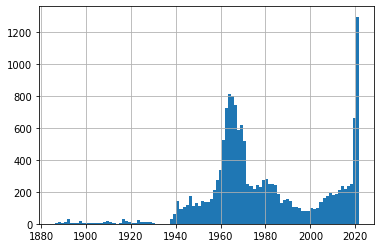

In [21]:
docs['pub_dates']= pd.to_datetime(docs['pub_dates'],format= '%d %B %Y' )
docs['pub_dates'].hist(bins=100)

In [23]:
# prepare the input for Bertopic
docs_abstract = docs['abstract'].to_list()

# **Topic Modeling**

The following steps will guide how to exploit Bertopic to perform topic modelling on the pre-pocessing data, i.e., the 16364 abstracts. 




## Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language. If you would like to use a multi-lingual model, please use `language="multilingual"` instead. 

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model. 

**NOTE**: Use `language="multilingual"` to select a model that support 50+ languages.


### (Custom) Embedding Models Test
- set to nr_topics='auto'
  - 2021-08-30 20:18:27,084 - BERTopic - Reduced number of topics from 246 to 155



In [31]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs_abstract)

Batches:   0%|          | 0/512 [00:00<?, ?it/s]

2021-10-02 02:53:50,021 - BERTopic - Transformed documents to Embeddings
2021-10-02 02:54:01,465 - BERTopic - Reduced dimensionality with UMAP
2021-10-02 02:54:44,972 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [32]:
freq = topic_model.get_topic_info(); freq.head()

Topic  Count                             Name
0     -1   6034            -1_gene_dna_rna_water
1      0    773    0_galaxies_solar_stars_galaxy
2      1    496  1_university_mr_dr_universities
3      2    220       2_auxin_plants_plant_wheat
4      3    203   3_trna_rna_ribosomal_ribosomes

In [33]:
counter = 0
for keyword in ['covid', 'perovskite', 'deep learning']:
  similar_topics, similarity = topic_model.find_topics(keyword, top_n=5)
  print(similar_topics)
  for i in topic_model.get_topic(similar_topics[0]):  # Select the most frequent topic
    print(i[0])

[12, 252, 162, 0, 219]
sarscov2
covid19
coronavirus
infection
antibodies
vaccine
viral
virus
antibody
vaccines
[226, 176, 78, 149, 234]
perovskite
perovskites
devices
films
nanocrystals
electroluminescence
photovoltaic
singlecrystal
optoelectronic
ferroelectricity
[109, 4, 63, 52, 1]
learning
intelligence
reinforcement
games
neural
game
ai
classification
starcraft
training


Here, we can save the pre-trained model.
Also, for later topic probability distribution and dynamic topic modelling, the corresponding probs and topics lists are needed.

In [35]:
topic_model.save('/content/drive/MyDrive/nature_scraping_bertopic/model/topic_model.pkl')

In [36]:
with open('/content/drive/MyDrive/nature_scraping_bertopic/model/topics', 'wb') as f_obj:
  pickle.dump(topics, f_obj)

In [37]:
with open('/content/drive/MyDrive/nature_scraping_bertopic/model/probs', 'wb') as f_obj:
  pickle.dump(probs, f_obj)

In [38]:
%ls /content/drive/MyDrive/nature_scraping_bertopic/model/

probs  topic_model.pkl  topics


## Extracting Topics
After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [34]:
%ls /content/drive/MyDrive/nature_scraping_bertopic/model/

probs  topics


In [ ]:
topic_model = BERTopic.load('/content/drive/MyDrive/nature_scraping_bertopic/model/topic_model.pkl')

In [ ]:
topic_model_update = BERTopic.load('/content/drive/MyDrive/nature_scraping_bertopic/model/topic_model.pkl')

In [ ]:
with open('/content/drive/MyDrive/nature_scraping_bertopic/model/topics', 'rb') as f_obj:
  topics = pickle.load(f_obj)

In [ ]:
with open('/content/drive/MyDrive/nature_scraping_bertopic/model/probs', 'rb') as f_obj:
  probs = pickle.load(f_obj)

In [39]:
freq = topic_model.get_topic_info(); freq.head(10)

Topic  Count                                               Name
0     -1   6034                              -1_gene_dna_rna_water
1      0    773                      0_galaxies_solar_stars_galaxy
2      1    496                    1_university_mr_dr_universities
3      2    220                         2_auxin_plants_plant_wheat
4      3    203                     3_trna_rna_ribosomal_ribosomes
5      4    202                   4_cortex_neurons_neural_stimulus
6      5    169                       5_mantle_basalts_magma_crust
7      6    168  6_photosynthesis_photosynthetic_chlorophyll_ph...
8      7    156                  7_cancer_mutations_tumours_tumour
9      8    149               8_variants_genome_genetic_sequencing

In [41]:
topic_model.get_topic(12)  # Select the most frequent topic

[('sarscov2', 0.03740669199873702),
 ('covid19', 0.025600077240678955),
 ('coronavirus', 0.019719227568593987),
 ('infection', 0.013407015070891443),
 ('antibodies', 0.012609548713081304),
 ('vaccine', 0.010472297131266088),
 ('viral', 0.00895473891706942),
 ('virus', 0.007159689474021142),
 ('antibody', 0.006578861604583553),
 ('vaccines', 0.006224569374230604)]

In [42]:
topic_model.get_topic(109)  # Select the most frequent topic

[('learning', 0.02301589120395162),
 ('intelligence', 0.01956275204771735),
 ('reinforcement', 0.018340080044735016),
 ('games', 0.01717588767314476),
 ('neural', 0.015534268730446846),
 ('game', 0.013354466712467726),
 ('ai', 0.009649912202997374),
 ('classification', 0.008225719533832755),
 ('starcraft', 0.00819169758591235),
 ('training', 0.008111309292056435)]

In [43]:
topic_model.get_topic(226)  # Select the most frequent topic

[('perovskite', 0.055635896603327434),
 ('perovskites', 0.04704790710564325),
 ('devices', 0.020977548670906416),
 ('films', 0.017039025713173776),
 ('nanocrystals', 0.015636877226995916),
 ('electroluminescence', 0.014317097328885212),
 ('photovoltaic', 0.014317097328885212),
 ('singlecrystal', 0.013758441887953183),
 ('optoelectronic', 0.012372507490442606),
 ('ferroelectricity', 0.010965253291882733)]

In [44]:
topic_model.visualize_heatmap(top_n_topics=40)

-1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated:

**NOTE**: BERTopic is stocastich which mmeans that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

# **Visualization**

## Visualize Topics
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good 
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation. 
Instead, we can visualize the topics that were generated in a way very similar to 
[LDAvis](https://github.com/cpsievert/LDAvis):

In [45]:
topic_model.visualize_topics()

## Visualize Topic Probabilities

The variable `probabilities` that is returned from `transform()` or `fit_transform()` can 
be used to understand how confident BERTopic is that certain topics can be found in a document. 

To visualize the distributions, we simply call:

In [61]:
docs.sort_values(by='pub_dates').tail()

titles  ...                                           abstract
11413  The contribution of insects to global forest d...  ...  The amount of carbon stored in deadwood is equ...
11414        Decision trees within a molecular memristor  ...  Profuse dendritic-synaptic interconnections am...
11415  Multiple hominin dispersals into Southwest Asi...  ...  Pleistocene hominin dispersals out of, and bac...
11400  Superconductivity in rhombohedral trilayer gra...  ...  Accessing superconductivity via the electric f...
11401  Half and quarter metals in rhombohedral trilay...  ...  Ferromagnetism is most common in transition me...

[5 rows x 10 columns]

In [68]:
docs.loc[11400]

titles          Superconductivity in rhombohedral trilayer gra...
pub_dates                                     2021-09-01 00:00:00
Accesses                                                     2828
Citations                                                     NaN
Altmetric                                                       7
affiliations    [Department of Physics, University of Californ...
corres_auths                                     Andrea F. Young.
dois                   https://doi.org/10.1038/s41586-021-03926-0
subjects        [Electronic properties and devices, Supercondu...
abstract        Accessing superconductivity via the electric f...
Name: 11400, dtype: object

In [75]:
docs.iloc[0]

titles             Politics of Nuclear Power in the United States
pub_dates                                     1971-10-15 00:00:00
Accesses                                                       55
Citations                                                       8
Altmetric                                                       0
affiliations    [Department of Physics, Harvard University, RI...
corres_auths                                                  NaN
dois                                                          NaN
subjects                                                      NaN
abstract        In this article the issues surrounding nuclear...
Name: 0, dtype: object

In [76]:
topic_model.visualize_distribution(probs[0], min_probability=0.015)

## Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [50]:
topic_model.visualize_hierarchy(top_n_topics=30)

In [51]:
topic_model.visualize_heatmap(n_clusters=30)

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [52]:
topic_model.visualize_barchart(topics=[1, 2, 3, 4, 5, 6, 12, 109, 226], n_words=9, width=1100, height=900)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [53]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [57]:
len(topic_model.topic_embeddings[0])

384

## Visualize Term Score Decline
Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.


In [55]:
topic_model.visualize_term_rank([12, 109, 226])

# **Topic Representation**
After having created the topic model, you might not be satisfied with some of the parameters you have chosen. Fortunately, BERTopic allows you to update the topics after they have been created. 

This allows for fine-tuning the model to your specifications and wishes. 

## Update Topics
When you have trained a model and viewed the topics and the words that represent them,
you might not be satisfied with the representation. Perhaps you forgot to remove
stopwords or you want to try out a different `n_gram_range`. We can use the function `update_topics` to update 
the topic representation with new parameters for `c-TF-IDF`: 


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
topic_model_update.update_topics(docs_abstract, topics, vectorizer_model=vectorizer_model)

In [ ]:
counter = 0
for keyword in ['covid', 'perovskit', 'deep learning']:
  similar_topics, similarity = topic_model_update.find_topics(keyword, top_n=5)
  print(similar_topics)
  for i in topic_model_update.get_topic(similar_topics[0]):  # Select the most frequent topic
    print(i[0])

# **Dynamic Topic Modeling**

### Perspective for topic evolution over 148 years from 1886 to 2021.

### Dynamic topic modelling from 2010

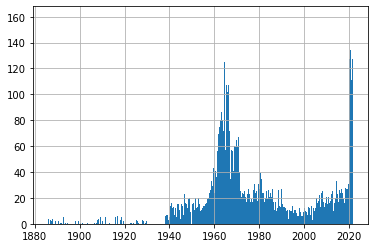

In [ ]:
docs['pub_dates'].hist(bins=1000)

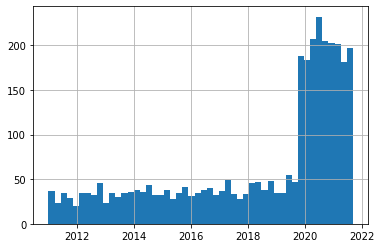

In [ ]:
docs_2010 = docs
docs_2010[docs_2010['pub_dates'].dt.year > 2010]['pub_dates'].hist(bins=50)
docs_2010 = docs_2010[docs_2010['pub_dates'].dt.year > 2010]

In [ ]:
docs_2010_abstract = docs_2010['abstract'].to_list();

In [ ]:
topic_model_2010 = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics_2010, probs_2010 = topic_model_2010.fit_transform(docs_2010_abstract)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2021-09-08 18:06:45,208 - BERTopic - Transformed documents to Embeddings
2021-09-08 18:07:04,720 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 18:07:05,666 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
timestamps_2010 = docs_2010['pub_dates'].to_list()

In [ ]:
topics_over_time_2010 = topic_model_2010.topics_over_time(docs=docs_2010_abstract, 
                                                topics=topics_2010, 
                                                timestamps=timestamps_2010, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=50)

50it [00:49,  1.01it/s]


In [ ]:
topic_model_2010.visualize_topics_over_time(topics_over_time_2010, topics=[1, 2, 3, 4, 5, 6, 40, 63])

### Full history

In [ ]:
timestamps = docs['pub_dates'].to_list()

In [ ]:
topics_over_time_3 = topic_model.topics_over_time(docs=docs_abstract, 
                                                topics=topics, 
                                                timestamps=timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=444)

367it [03:50,  1.59it/s]


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time_author, topics=[1, 2, 3, 4, 5, 6, 7, 10, 11, 23, 140, 225], width=1500, height=750)